In [15]:
from copy import deepcopy
from pathlib import Path

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import seaborn as sns

from netam import framework, models, experiment
from netam.common import pick_device, parameter_count_of_model
from netam.framework import load_shmoof_dataframes

%reload_ext autoreload

In [2]:
data_path = "/Users/matsen/data/greiff-systems-oof_pcp_2023-11-30_MASKED.csv"
df = pd.read_csv(data_path, index_col=0)

df = df[df["parent"] != df["child"]]

frac_long_seqs = (df["parent"].str.len() > 410).sum() / len(df)
print(f"Fraction of long sequences: {frac_long_seqs:.2g}")

Fraction of long sequences: 0.0048


In [3]:
train_sample_ids = ['hepb-vax_m4_plasma', 'no-vax_m2_plasma', 'np-hel-vax_m2_plasma',
        'ova-vax_m4_plasma', 'np-hel-vax_m3_plasma', 'no-vax_m1_plasma',
        'ova-vax_m2_plasma', 'hepb-vax_m3_plasma', 'ova-vax_m5_plasma',
        'hepb-vax_m1_plasma', 'no-vax_m3_plasma', 'no-vax_m4_plasma',
        'ova-vax_m3_plasma', 'np-hel-vax_m1_plasma',
        'np-hel-vax_m5_plasma']
val_sample_ids = ['no-vax_m5_plasma', 'ova-vax_m1_plasma', 'hepb-vax_m2_plasma',
        'np-hel-vax_m4_plasma']

train_df = df[df["sample_id"].isin(train_sample_ids)]
val_df = df[df["sample_id"].isin(val_sample_ids)]

assert len(train_df) + len(val_df) == len(df)

In [4]:
expt = experiment.Experiment()

train_data_by_kmer_length = expt.data_by_kmer_length_of(train_df)
val_data_by_kmer_length = expt.data_by_kmer_length_of(val_df)

Using Metal Performance Shaders


In [5]:
training_params_by_model_name = {
    "mm_cnn_lrg": {"l2_regularization_coeff": 5e-7},
}

expt_df = expt.build_experiment_df("mm", train_data_by_kmer_length, val_data_by_kmer_length, training_params_by_model_name)

def view(expt_df):
    return expt_df.drop(columns=["model", "train_dataset", "val_dataset"])
    
view(expt_df)

,model_name,parameter_count,kmer_length,training_params
0,mm_cnn_sml,1007,3,{}
1,mm_cnn_med,1495,3,{}
2,mm_cnn_lrg,1957,3,{'l2_regularization_coeff': 5e-07}
3,mm_cnn_4k,3665,3,{}
4,mm_cnn_8k,6211,3,{}
5,mm_fivemer,1025,5,{}
6,mm_shmoof,1525,5,{}


In [6]:
expt.train_experiment_df(expt_df)

	Training mm_cnn_sml...


Epoch:   0%|          | 3/1000 [00:51<4:43:26, 17.06s/it, loss_diff=-7.75e-05, lr=0.1, val_loss=0.03549]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_22883/3601444846.py", line 1, in <module>
    expt.train_experiment_df(expt_df)
  File "/Users/matsen/re/netam/netam/experiment.py", line 180, in train_experiment_df
  File "/Users/matsen/re/netam/netam/experiment.py", line 119, in train_or_load
    )
  File "/Users/matsen/re/netam/netam/framework.py", line 380, in train
    train_loss = self.process_data_loader(
  File "/Users/matsen/re/netam/netam/framework.py", line 334, in process_data_loader
    loss.backward()
  File "/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/torch/_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/torch/autograd/__init__.py", li

In [11]:
for model in expt_df["model"]:
    model.to(expt.device)

In [12]:
expt_df["val_loss"] = expt.loss_of_dataset_dict(expt_df, val_data_by_kmer_length)

In [16]:
experiment.plot_loss_difference(expt_df, baseline_model_name='mm_fivemer')


AttributeError: module 'netam.experiment' has no attribute 'plot_loss_difference'

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def mutation_count_of_row(row):    
    return sum(
        1 for p, c in zip(row["parent"], row["child"]) if p != c and p != "N" and c != "N"
    )    

df['mutation_count'] = df.apply(mutation_count_of_row, axis=1)


(1.0, 20.0)

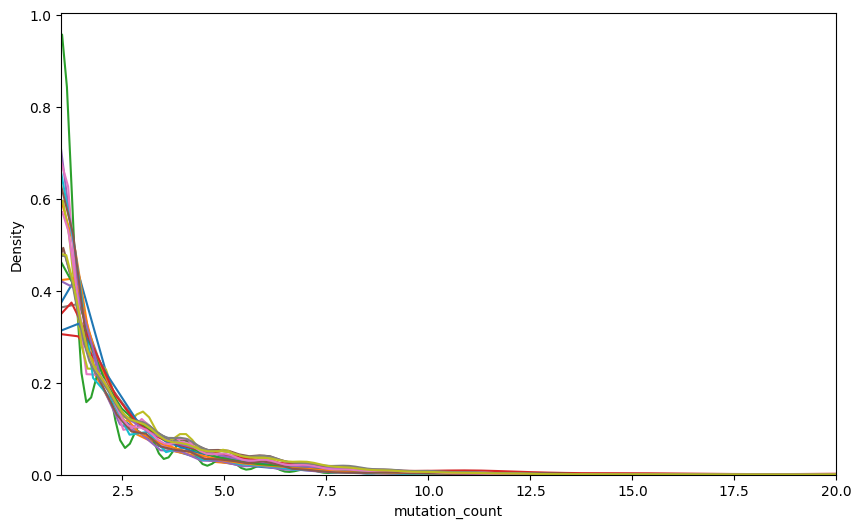

In [11]:

# make a kdeplot of the mutation count with one line per sample_id
fig, ax = plt.subplots(figsize=(10, 6))
for sample_id in df["sample_id"].unique():
    sns.kdeplot(
        data=df[df["sample_id"] == sample_id],
        x="mutation_count",
        label=sample_id,
        ax=ax,
    )
plt.xlim(1, 20)

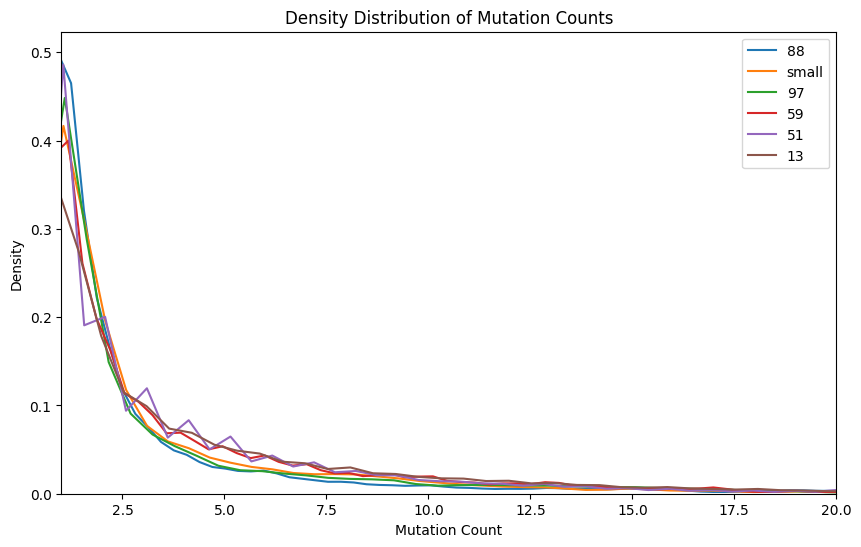

In [7]:
import seaborn as sns

plt.figure(figsize=(10, 6))
for nickname, counts in mutation_counts.items():
    sns.kdeplot(counts, label=nickname, bw_adjust=0.5)

plt.xlim(1, 20)
plt.xlabel('Mutation Count')
plt.ylabel('Density')
plt.title('Density Distribution of Mutation Counts')
plt.legend()
plt.show()
